In [13]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [14]:
print(cancer.data.shape, cancer.target.shape)

(569, 30) (569,)


In [15]:
cancer.data[:3]

array([[1.799e+01, 1.038e+01, 1.228e+02, 1.001e+03, 1.184e-01, 2.776e-01,
        3.001e-01, 1.471e-01, 2.419e-01, 7.871e-02, 1.095e+00, 9.053e-01,
        8.589e+00, 1.534e+02, 6.399e-03, 4.904e-02, 5.373e-02, 1.587e-02,
        3.003e-02, 6.193e-03, 2.538e+01, 1.733e+01, 1.846e+02, 2.019e+03,
        1.622e-01, 6.656e-01, 7.119e-01, 2.654e-01, 4.601e-01, 1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, 1.326e+03, 8.474e-02, 7.864e-02,
        8.690e-02, 7.017e-02, 1.812e-01, 5.667e-02, 5.435e-01, 7.339e-01,
        3.398e+00, 7.408e+01, 5.225e-03, 1.308e-02, 1.860e-02, 1.340e-02,
        1.389e-02, 3.532e-03, 2.499e+01, 2.341e+01, 1.588e+02, 1.956e+03,
        1.238e-01, 1.866e-01, 2.416e-01, 1.860e-01, 2.750e-01, 8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, 1.203e+03, 1.096e-01, 1.599e-01,
        1.974e-01, 1.279e-01, 2.069e-01, 5.999e-02, 7.456e-01, 7.869e-01,
        4.585e+00, 9.403e+01, 6.150e-03, 4.006e-02, 3.832e-02, 2.058e-02,
        2.250e-02, 4.571e-03, 2.357e

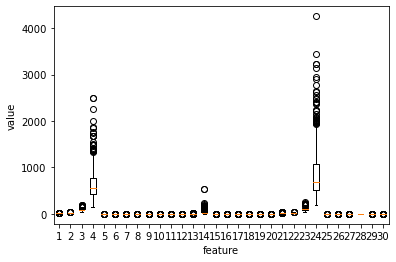

In [16]:
plt.boxplot(cancer.data)
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

In [17]:
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target

x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

In [18]:
# 검증세트 분할
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [35]:
# 가중치를 기록하는 변수와 학습률 파라미터 추가

class SingleLayer:
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2
        
    def forpass(self, x):
        z = np.dot(x, self.w) + self.b # 직선 방정식을 계산
        return z 
    
    def backprop(self, x, err):
        m = len(x)
        w_grad = np.dot(x.T, err) / m # 가중치에 대한 그래디언트 계산
        b_grad = np.sum(err) / m  # 절편에 대한 그래디언트 계산
        return w_grad, b_grad
    
    def activation(self, z):
        z = np.clip(z, -100, None) # 안전한 np.exp() 계산을 위해 
        a = 1 / (1 + np.exp(-z)) # 시그모이드 계산 
        
        return a 
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        m = len(x)
        self.w = np.ones((x.shape[1], 1))
        self.b = 0
        self.w_history.append(self.w.copy()) # 가중c치 기록 
        
        # 전체 샘플을 한번에 계산 : 배치 경사 하강법
        for i in range(epochs):
            z = self.forpass(x)
            a = self.activation(z)

            err = -(y - a)
            # 오차를 역전파하여 그래디언트 계산 
            w_grad, b_grad = self.backprop(x, err) # 역방향 계산

            # 그래디언트에서 패널티 항의 미분 값을 더한다. 
            w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w / m
            # 가중치와 절편 업데이트 
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad
        
            # 가중치 기록
            self.w_history.append(self.w.copy())

            # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적 
            a = np.clip(a, 1e-10, 1-1e-10)
            
            # 로그 손실과 규제 손실을 더하여 리스트에 추가
            loss = -(y*np.log(a) + (1-y)*np.log(1-a))
            
            self.losses.append(loss + self.reg_loss() / m)


            # 검증 세트에 대한 손실 계산
            self.update_val_loss(x_val, y_val)
    
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]
        return np.array(z) > 0 # 스텝 함수 적용
        
    def score(self, x, y):
        return np.mean(self.predict(x)==y)
    

    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
    
    def update_val_loss(self, x_val, y_val):
        # 검증 세트 손실 기록 로지스틱 손실
        m = len(x_val)
        if x_val is None:
            return 
        val_loss = 0
        for i in range(len(x_val)):
            z = self.forpass(x_val)
            a = self.activation(z)
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val*np.log(a)+(1-y_val)*np.log(1-a))
        self.val_losses.append(val_loss + self.reg_loss() / m)
            

In [36]:
layer1 = SingleLayer()
layer1.fit(x_train, y_train, x_val=x_val, y_val=y_val)
layer1.score(x_val, y_val)

0.6180412993599806

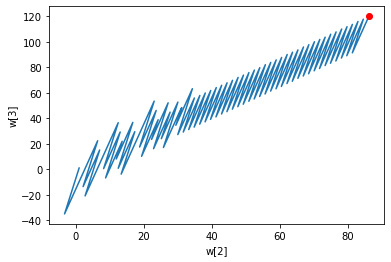

In [34]:
w2 = [] # mean perimeter

w3 = [] # mean area

for w in layer1.w_history:
    w2.append(w[2])
    
    w3.append(w[3])
    
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')

plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()
# 스케일을 조정하지 않으면, 가중치 변화가 불안정하고, 최종 가중치를 찾는 과정이 비효율적


In [39]:
# 표준화 진행
train_mean = np.mean(x_train, axis=0)

train_std = np.std(x_train, axis=0)

x_train_scaled = (x_train - train_mean) / train_std

In [41]:
layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train, x_val=x_val, y_val=y_val)

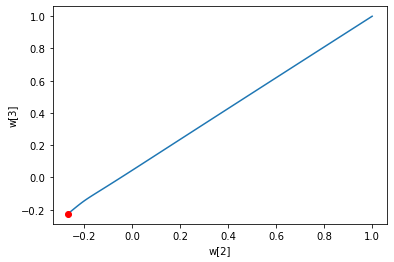

In [42]:
w2 = [] # mean perimeter

w3 = [] # mean area

for w in layer2.w_history:
    w2.append(w[2])
    
    w3.append(w[3])
    
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')

plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()
# 스케일을 조정하지 않으면, 가중치 변화가 불안정하고, 최종 가중치를 찾는 과정이 비효율적


In [43]:
x_val_scaled = (x_val - train_mean) / train_std

In [44]:
layer3 = SingleLayer()
layer3.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

In [49]:
layer3.score(x_val_scaled, y_val)

0.5374954715614056

In [54]:
# 두개의 층을 가진 다층 신경망 

class DualLayer:
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2
        self.units = 2
        
 

    def forpass(self, x):
        z = np.dot(x, self.w) + self.b # 직선 방정식을 계산
        return z 
    
    def backprop(self, x, err):
        m = len(x) 
        
        w2_grad = np.dot(a1.T, err) / m # 가중치에 대한 그래디언트 계산
        b2_grad = np.sum(err) / m  # 절편에 대한 그래디언트 계산
        # 시그모이드 함수까지 그래디언트 계산
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1-self.a1)
        # 은닉층의 가중치와 절편에 대한 그래디언트를 계산
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad
    def activation(self, z):
        z = np.clip(z, -100, None) # 안전한 np.exp() 계산을 위해 
        a = 1 / (1 + np.exp(-z)) # 시그모이드 계산 
        
        return a 
    def fit(self, x, y, epochs=None, x_val=None, y_val=None):
        y = y.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        m = len(x)
        self.w = np.ones((x.shape[1], 1))
        self.b = 0
        self.w_history.append(self.w.copy()) # 가중c치 기록 
        
        # 전체 샘플을 한번에 계산 : 배치 경사 하강법
        for i in range(epochs):
            z = self.forpass(x)
            a = self.activation(z)

            err = -(y - a)
            # 오차를 역전파하여 그래디언트 계산 
            w_grad, b_grad = self.backprop(x, err) # 역방향 계산

            # 그래디언트에서 패널티 항의 미분 값을 더한다. 
            w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w / m
            # 가중치와 절편 업데이트 
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad
        
            # 가중치 기록
            self.w_history.append(self.w.copy())

            # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적 
            a = np.clip(a, 1e-10, 1-1e-10)
            
            # 로그 손실과 규제 손실을 더하여 리스트에 추가
            loss = -(y*np.log(a) + (1-y)*np.log(1-a))
            
            self.losses.append(loss + self.reg_loss() / m)


            # 검증 세트에 대한 손실 계산
            self.update_val_loss(x_val, y_val)
    
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]
        return np.array(z) > 0 # 스텝 함수 적용
        
    def score(self, x, y):
        return np.mean(self.predict(x)==y)
    

    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
    
    def update_val_loss(self, x_val, y_val):
        # 검증 세트 손실 기록 로지스틱 손실
        m = len(x_val)
        if x_val is None:
            return 
        val_loss = 0
        for i in range(len(x_val)):
            z = self.forpass(x_val)
            a = self.activation(z)
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val*np.log(a)+(1-y_val)*np.log(1-a))
        self.val_losses.append(val_loss + self.reg_loss() / m)
        

class RandomInitNetwork(DualLayer):
    def init_weight(self, n_features):
        self.w1 = np.ones((n_features, self.units)) # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)
        self.w2 = np.ones((self.units, 1))
        self.b2 = 0



In [60]:
dual_later = DualLayer(l2=0.01)
dual_later.init_weight(30)

In [61]:
dual_later.fit(x_train_scaled, y_train, epochs=20000, x_val=x_val_scaled, y_val=y_val)

NameError: name 'a1' is not defined